In [1]:
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore")


pd.options.display.max_columns = 50

custom_params = {"axes.spines.left": False, "axes.spines.bottom": False, "axes.spines.top":False, "axes.spines.right":False}
sns.set_theme(rc = custom_params, style="white", palette="muted", font_scale=1) #Muted #pastel

In [2]:
boruta_cols = ['international_plan', 'total_intl_calls', 'total_eve_minutes', 'recharge_total', 'number_customer_service_calls', 'total_intl_minutes', 'voice_mail_plan']
#lgbm_boruta_cols = ['recharge_total', 'total_eve_minutes', 'voice_mail_plan', 'total_intl_minutes', 'international_plan', 'number_customer_service_calls', 'total_intl_calls']

params_dt = {'class_weight': None,
'max_depth': 5,
'min_samples_leaf': 7,
'splitter': 'best'}

params_lgbm = {'lambda_l1': 0,
'lambda_l2': 25,
'learning_rate': 0.27140590028960937,
'max_depth': 3,
'min_data_in_leaf': 80,
'n_estimators': 10000,
'num_leaves': 480}

In [5]:
train_raw = pd.read_csv("../data/train_FE.csv")
test_raw = pd.read_csv("../data/test_FE.csv")

In [6]:
X_train, y_train = train_raw[boruta_cols], train_raw.churn 
X_test, y_test = test_raw[boruta_cols], test_raw.churn 

In [7]:
dt = CalibratedClassifierCV(DecisionTreeClassifier(random_state = 42, **params_dt), cv = 10)
lgbm = make_pipeline(StandardScaler(), CalibratedClassifierCV(LGBMClassifier(random_state = 42, verbose=-1, **params_lgbm), cv = 10))
logit = make_pipeline(StandardScaler(), LogisticRegression(random_state = 42))
rf = RandomForestClassifier(n_estimators=300,min_samples_leaf=20, max_depth=5, random_state=42)
knn = KNeighborsClassifier()
svm = SVC(kernel="poly", degree=3, probability=True, random_state=42, C=0.25)

In [ ]:
def get_balanco(X_train, y_train, X_test, y_test, model, retention_taxe):

    #constantes
    retention_taxe = retention_taxe
    retention_cost = X_test.recharge_total.mean() / 5

    #obtendo previsões
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)

    #criar DataFrame (df) temporário com valores observado, previstos e valor total de cobranças
    df = pd.DataFrame({"true_label": y_test, "predict_label":y_hat, "recharge": X_test["recharge_total"]})

    #preencher df com rótulos da confusion matrix
    def fill_df(row):
        if (row["true_label"] == 0 ) and (row["predict_label"] == 0):
            return "TN" 
        if (row["true_label"] == 0 ) and (row["predict_label"] == 1):
            return "FP"
        if (row["true_label"] == 1 ) and (row["predict_label"] == 0):
            return "FN"
        if (row["true_label"] == 1 ) and (row["predict_label"] == 1):
            return "TP"

    df["cm_rotule"] = df.apply(lambda row: fill_df(row), axis = 1)

    #amostragem dos TP: clientes retidos, depende da taxa de retenção
    df_sample = df[df["cm_rotule"] == "TP"].sample(frac = retention_taxe, random_state = 42)

    # df com o restante dos TPs (clientes rotativos)
    df_ = df.drop(df_sample.index, axis = 0)

    #retorno de cada categoria
    rTN = df_[df_["cm_rotule"] == "TN"]["recharge"].sum()
    rTP_retidos = df_sample[df_sample["cm_rotule"] == "TP"]["recharge"].sum()
    rTP_nao_retidos = df_[df_["cm_rotule"] == "TP"]["recharge"].sum() 
    rFP = df_[df_["cm_rotule"] == "FP"]["recharge"].sum()
    rFN = df_[df_["cm_rotule"] == "FN"]["recharge"].sum() 

    #clientes rotulados pelo modelo como churn (TP e FP) tem custo de retenção
    retention_cost = df[(df["cm_rotule"] == "TP") | (df["cm_rotule"] == "FP")]["recharge"].count() * retention_cost

    #calculo final
    receita = rTN + rFP + rTP_retidos 
    prejuizo = retention_cost + rFN + rTP_nao_retidos
    balanco = receita - prejuizo

    return balanco

In [ ]:
models = {}
models["Logit"] = logit
models["LGBM"] = lgbm
models["Decision Tree"] = dt
models["SVM"] = svm
models["Random Forest"] = rf
models["KNN"] = knn

In [ ]:
#inicializando dicionario com resultado final
result = {}
result["a"] = []
for name in models.keys():
    result[name] = []
    
#iterando por diferentes taxa de retenção e modelos 
for taxe in np.linspace(0.02, 1, 10):
    result["a"].append(taxe)
    for name, model in models.items():
        bal = get_balanco(X_train, y_train, X_test, y_test, model, taxe)
        result[name].append(bal)
        
        
df_melt = pd.DataFrame(result).melt(id_vars="a", var_name="model", value_name="profit")        

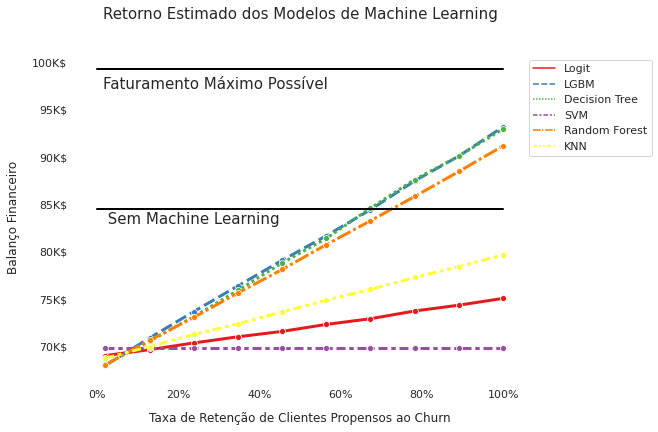

In [ ]:
#balanço sem ML
x1 = [0,1]
y1 = [84577,84577]

#Baçanço maximo sem perda por churn
x2 = [0,1]
y2 = [99317, 99317]

fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(x= "a",
                y='profit',
                data=df_melt,
                hue='model',
                ax=ax,
                linewidth= 3 ,
             marker = "o",
             style='model',
            palette="Set1",
            alpha = 1)
ax.plot(x1,y1, linewidth=2, color = "black")
ax.plot(x2,y2, linewidth=2, color = "black")

ax.xaxis.set_major_formatter(lambda x, pos: f"{x*100:.0f}%") #ax.xaxis.set_major_formatter('{x:.0f}%')
ax.yaxis.set_major_formatter(lambda x, pos: f"{x/1000:.0f}K$")

ax.annotate(text=' Sem Machine Learning', xy=(1, 84577), xycoords='data', size = 15, xytext=(-400, -15), textcoords='offset points')
ax.annotate(text='Faturamento Máximo Possível', xy=(1, 99318), xycoords='data', size = 15, xytext=(-400, -20), textcoords='offset points')


ax.set_xlabel("Taxa de Retenção de Clientes Propensos ao Churn", labelpad=12)
ax.set_ylabel("Balanço Financeiro", labelpad=12)
ax.set_title("Retorno Estimado dos Modelos de Machine Learning", pad = 35, fontdict = {"fontsize":15})

L = ax.legend(loc = 0, title = "", bbox_to_anchor = (1,1))
plt.savefig('ROI_ML.png', dpi = 600,  bbox_inches='tight')
plt.show();
